In [1]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Loading in the data
df=pd.read_csv('/content/drive/My Drive/household_power_consumption.txt', sep = ';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'],na_values = '?', dtype = float)

In [2]:
# Viewing the first 5 rows of the dataset
df.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [3]:
# Checking for missing values
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [4]:
# Creating a copy
df_copy = df.copy()

In [5]:
# Downsampling
df_daily = df_copy.resample('D').sum()
print(df_daily)

            Global_active_power  ...  Sub_metering_3
datetime                         ...                
2006-12-16             1209.176  ...          4926.0
2006-12-17             3390.460  ...         13341.0
2006-12-18             2203.826  ...         14018.0
2006-12-19             1666.194  ...          6197.0
2006-12-20             2225.748  ...         14063.0
...                         ...  ...             ...
2010-11-22             2041.536  ...         10136.0
2010-11-23             1577.536  ...          7611.0
2010-11-24             1796.248  ...         12224.0
2010-11-25             1431.164  ...          5072.0
2010-11-26             1488.104  ...          9989.0

[1442 rows x 7 columns]


In [6]:
df_daily.fillna(df_daily.mean(), inplace = True)

In [7]:
df_daily.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Text(0, 0.5, 'G_A_P')

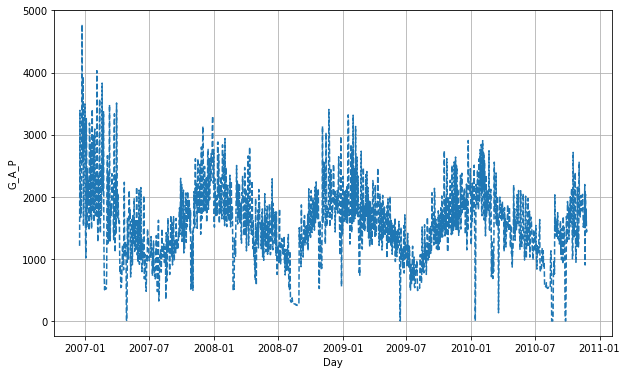

In [8]:
# Plot for global_active_power over time
plt.figure(figsize=(10,6))
plt.plot(df_daily.index, df_daily.Global_active_power, '--')
plt.grid()
plt.xlabel('Day')
plt.ylabel('G_A_P')

In [9]:
# Pearson correlation
from scipy.stats import pearsonr

corr1 = pearsonr(df_daily.Global_active_power, df_daily.Global_reactive_power)[0]
print(corr1)

0.1285075044962244


In [10]:
r, p = pearsonr(df_daily['Voltage'], df_daily['Global_intensity'])
print(r)

0.274402918038032


In [11]:
# Univariate time series
new_df = df_daily.reset_index()
new_df = new_df[['datetime', 'Global_active_power']]

new_df = new_df.rename(columns={'datetime': 'ds', 'Global_active_power': 'y'})
new_df.head()

,ds,y
0,2006-12-16,1209.176
1,2006-12-17,3390.460
2,2006-12-18,2203.826
3,2006-12-19,1666.194
4,2006-12-20,2225.748


In [12]:
train = new_df[:-365]
test = new_df[-365:]

In [13]:
from fbprophet import Prophet

model = Prophet()

In [14]:
model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
forecast = model.predict(test)

In [16]:
a = np.array(test['y'])
b = np.array(forecast['yhat'])

In [17]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(a, b)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in true_divide



inf

In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(a, b))
print(rms)

441.4333840973149


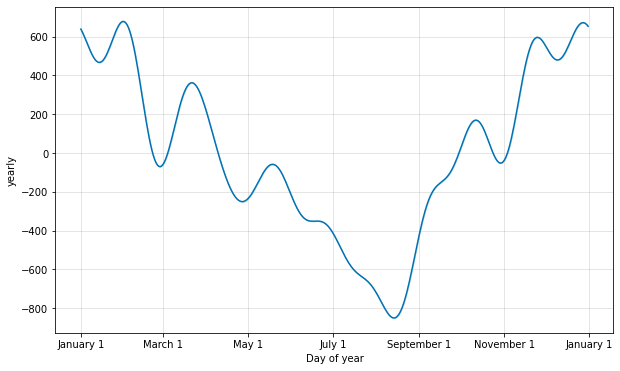

In [19]:
# Yearly seasonality
from fbprophet.plot import plot_yearly
plot_yearly(model)

In [20]:
# Multivariate time series
n_df = df_daily.reset_index()
n_df = n_df[['datetime', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]

n_df = n_df.rename(columns={'datetime': 'ds', 'Global_active_power': 'y', 'Global_reactive_power': 'add1', 'Voltage': 'add2', 'Global_intensity': 'add3', 'Sub_metering_1': 'add4', 'Sub_metering_2': 'add5', 'Sub_metering_3': 'add6'})
n_df.head()

,ds,y,add1,add2,add3,add4,add5,add6
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [21]:
train2 = n_df.iloc[:1077, :]
test2 = n_df.iloc[1077:,:]

In [22]:
modell = Prophet()
# Adding regressors
modell.add_regressor('add1')
modell.add_regressor('add2')
modell.add_regressor('add3')
modell.add_regressor('add4')
modell.add_regressor('add5')
modell.add_regressor('add6')

modell.fit(train2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
forecast2 = modell.predict(test2)

In [24]:
c = np.array(test2.y)
d = np.array(forecast2.yhat)

mean_absolute_percentage_error(c, d)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in true_divide



inf

In [25]:
rmse = sqrt(mean_squared_error(c, d))
rmse

39.39524688130152

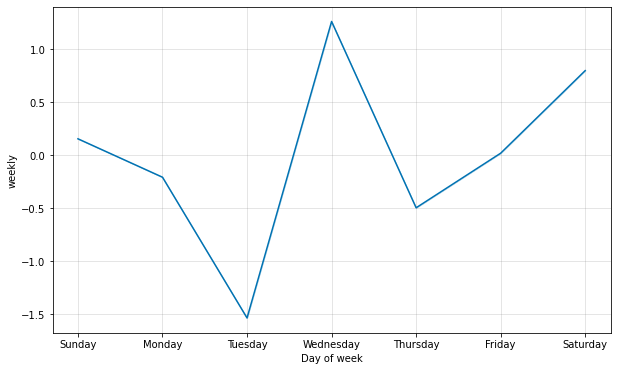

In [26]:
# Weekly seasonality
from fbprophet.plot import plot_weekly
plot_weekly(modell)